# NBA Coach's Challenge

_1/25/2020_

_Note, all analysis below uses challenge data from NBA games played through 1/20/2020_

For the 2019-20 NBA season, the NBA has adopted the Coach's Challenge. Once per game, a team can challenge a called foul, called out-of-bounds violation, or called goaltending or basket interference. [This video](https://twitter.com/NBAOfficial/status/1178742322584068097?s=20) describes the process in more detail along with showing examples. [This site](https://official.nba.com/2019-20-nba-coachs-challenge-results/) shows the challenged plays by date, along with a cumulative tally of the challenge results.

The goal of this notebook is to explore the challenges that have occurred so far and use data visualization to further enhance the takeaways from the data available on the website linked above.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools
from datetime import datetime, timedelta

from PIL import Image
import PIL.ImageOps    
import time

from py_ball import image, boxscore, scoreboard

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

TEAM_TO_ID_NBA = {'TOR': '1610612761', 'DEN': '1610612743',
                  'DET': '1610612765', 'NOP': '1610612740',
                  'MIL': '1610612749', 'GSW': '1610612744',
                  'SAS': '1610612759', 'POR': '1610612757',
                  'LAC': '1610612746', 'DAL': '1610612742',
                  'MEM': '1610612763', 'PHI': '1610612755',
                  'BOS': '1610612738', 'MIN': '1610612750',
                  'CHA': '1610612766', 'IND': '1610612754',
                  'ORL': '1610612753', 'MIA': '1610612748',
                  'HOU': '1610612745', 'SAC': '1610612758',
                  'UTA': '1610612762', 'BKN': '1610612751',
                  'ATL': '1610612737', 'PHX': '1610612756',
                  'WAS': '1610612764', 'NYK': '1610612752',
                  'OKC': '1610612760', 'LAL': '1610612747',
                  'CLE': '1610612739', 'CHI': '1610612741'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

Let's take a look at the challenge data and do some exploration. These data were sourced from the above official's challenge site that contains each play challenged this season, along with a document produced each day to summarize season-to-date challenges.

In [2]:
challenge_df = pd.read_csv('challenge.csv', encoding = "ISO-8859-1")
challenge_df.head()

,Date,Visiting,Home,Period,Time,Challenging Team,Challenge Type,Result,Link
0,20-Jan,WAS,DET,3rd,1:24,DET,Foul,Successful,https://dmmx2.nba.com/videourlredirect?&projec...
1,20-Jan,TOR,ATL,4th,4:58,TOR,Foul,Successful,https://dmmx2.nba.com/videourlredirect?&projec...
2,20-Jan,TOR,ATL,4th,3:05,ATL,OB,Unsuccessful,https://dmmx2.nba.com/videourlredirect?&projec...
3,20-Jan,ORL,CHA,3rd,1:43,ORL,Foul,Unsuccessful,https://dmmx2.nba.com/videourlredirect?&projec...
4,20-Jan,OKC,HOU,2nd,1:05,OKC,Foul,Unsuccessful,https://dmmx2.nba.com/videourlredirect?&projec...


Immediately, we can gather some ideas on how to visualize these data:
    - Success by team
    - Success by quarter
    - Success by challenge type
    
Additionally, we could pull in the officials in the game and examine success by officiating crew. Let's start with visualizing success by team, then tackle the other options.

## Challenges by Team

In [3]:
challenge_df['Success'] = [1 if x == 'Successful' else 0 for x in challenge_df['Result']]
challenge_df['Challenging Team'] = ['UTA' if x == 'UT'
                                    else 'BOS' if x == 'Bos'
                                    else x for x in challenge_df['Challenging Team']]
team_df = pd.DataFrame(challenge_df.groupby('Challenging Team')['Success'].aggregate(['sum', 'count'])).reset_index()
team_df['success_rate'] = [0 if y == 0 else x/float(y) for x, y in zip(team_df['sum'], team_df['count'])]
for team in TEAM_TO_ID_NBA:
    if team not in list(team_df['Challenging Team']):
        temp_df = pd.DataFrame({'Challenging Team': [team],
                                'sum': [0],
                                'count': [0],
                                'success_rate': [0]})
        team_df = pd.concat([team_df, temp_df], axis=0)
team_df = team_df.sort_values(['sum', 'count', 'success_rate'], ascending=[True, True, False])
team_df['success_rate'] = [round(x, 2) for x in team_df['success_rate']]
team_df

,Challenging Team,sum,count,success_rate
18,NOP,0,7,0.00
7,DEN,1,7,0.14
14,MEM,2,3,0.67
12,LAC,2,8,0.25
3,CHA,3,7,0.43
5,CLE,3,11,0.27
13,LAL,3,12,0.25
29,WAS,3,12,0.25
17,MIN,4,10,0.40
28,UTA,4,10,0.40


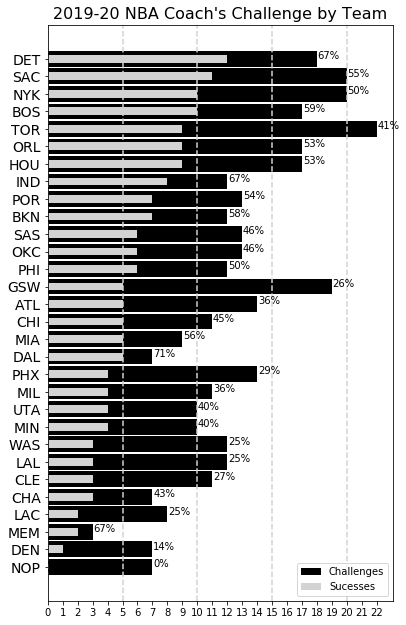

In [4]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes([0., 0., 0.8, 1., ])

# A nested bar chart should provide a nice visual
bar_height_po = 0.9
bar_height_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
vert_locations = np.arange(len(team_df))
#vert_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.barh(y=vert_locations,
        width=list(team_df['count']), height=bar_height_po,
        color='black', label = 'Challenges')
plt.barh(y=vert_locations,
        width=list(team_df['sum']), height=bar_height_league,
        color='lightgray', label = 'Sucesses')

count = 0
for perc, chal in zip(team_df['success_rate'], team_df['count']):
    plt.text(chal + 0.05, count, str(round(perc*100)) + '%')
    count += 1

plt.yticks(range(0, len(team_df)),
           team_df['Challenging Team'],
           rotation=0, fontsize=14)

plt.xticks(np.arange(0, max(team_df['count']) + 1, step=1))
for x in np.arange(0, max(team_df['count']) + 1, step=5):
    plt.axvline(x, linestyle='--', color='lightgray')
plt.title("2019-20 NBA Coach's Challenge by Team", fontsize=16)
plt.legend(loc='lower right')
plt.show()

The figure above shows a wide variety of both challenge usage and success. Seven teams have five or fewer challenges, a peculiar finding given the low cost of using one, which is only a timeout if the challenge is lost. No team has used a challenge in even half of their games, so there seems to be quite an inefficiency in challenge usage so far in the early season.

More than half of the league has yet to win more than five challenges, indicating that a team's reluctance to use a challenge is not leading to higher success rates. Despite widespread public aversion to the coach's challenge as noted [here](https://www.espn.com/nba/story/_/id/28218555/nba-coach-challenge-rocky-start?platform=amp) at the beginning of December, some teams are taking advantage of the new rule. Notably, teams publicly perceived to rely on data-driven processes seem to both challenge more and achieve more success. Toronto, Sacramento, Houston, and Boston all have more than ten challenges and a success rate greater than 50%.

## Challenges by Type

In [5]:
challenge_df['Challenge Type'] = ['OB' if x == 'ob'
                                  else 'GT' if x == 'BI'
                                  else x for x in challenge_df['Challenge Type']]
type_df = pd.DataFrame(challenge_df.groupby('Challenge Type')['Success'].aggregate(['sum', 'count'])).reset_index()
type_df['success_rate'] = [0 if y == 0 else x/float(y) for x, y in zip(type_df['sum'], type_df['count'])]

type_df = type_df.sort_values(['sum', 'count', 'success_rate'], ascending=[True, True, False])
type_df['success_rate'] = [round(x, 2) for x in type_df['success_rate']]
type_df

,Challenge Type,sum,count,success_rate
1,GT,9,14,0.64
2,OB,34,45,0.76
0,Foul,125,319,0.39


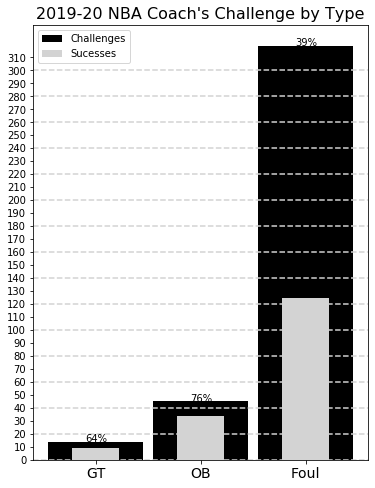

In [6]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes()

bar_width_po = 0.9
bar_width_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
hort_locations = np.arange(len(type_df))
#hort_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.bar(x=hort_locations,
        height=list(type_df['count']), width=bar_width_po,
        color='black', label = 'Challenges')
plt.bar(x=hort_locations,
        height=list(type_df['sum']), width=bar_width_league,
        color='lightgray', label = 'Sucesses')

count = 0
for perc, chal in zip(type_df['success_rate'], type_df['count']):
    plt.text(count-0.1, chal + 0.1, str(round(perc*100)) + '%')
    count += 1

plt.xticks(range(0, len(type_df)),
           type_df['Challenge Type'],
           rotation=0, fontsize=14)

plt.yticks(np.arange(0, max(type_df['count']) + 1, step=10))
for x in np.arange(0, max(type_df['count']) + 1, step=20):
    plt.axhline(x, linestyle='--', color='lightgray')
plt.title("2019-20 NBA Coach's Challenge by Type", fontsize=16)
plt.legend(loc='upper left')
plt.show()

This matches the data from the official NBA site and intuition. Goaltending and out-of-bounds calls are more objective than foul calls, meaning the required evidence for overturning is likely clearer. Check out [this](http://dmmx2.nba.com/videourlredirect?&project=/bbops/bbops_SAC_PHX_Phoenix_OB_Challenge_102319) overturned out-of-bounds call and [this](https://dmmx2.nba.com/videourlredirect?&project=/bbops/bbops_IND_DET_Indiana_Goaltending_Challenge_102818_v2) overturned goaltending. Called fouls are likely also much more ubiquitous than unlcear out-of-bounds or goaltending violations, which leads to challenges of fouls dominating the totals here. There appears to be two inefficiencies here. One, teams seem to be poor judges on foul calls against them. Two, unclear out-of-bounds reviews happen fairly frequently at the end of games, which could indicate that teams are not challenging these types of calls enough.

## Challenges by Quarter

In [7]:
challenge_df['Period'] = ['4th' if x == '4TH' else x for x in challenge_df['Period']]
quarter_df = pd.DataFrame(challenge_df.groupby('Period')['Success'].aggregate(['sum', 'count'])).reset_index()
quarter_df['success_rate'] = [0 if y == 0 else x/float(y) for x, y in zip(quarter_df['sum'], quarter_df['count'])]

quarter_df = quarter_df.sort_values(['Period'], ascending=[True])
quarter_df['success_rate'] = [round(x, 2) for x in quarter_df['success_rate']]
quarter_df

,Period,sum,count,success_rate
0,1st,17,26,0.65
1,2nd,32,60,0.53
2,3rd,44,97,0.45
3,4th,75,192,0.39
4,OT1,0,3,0.00


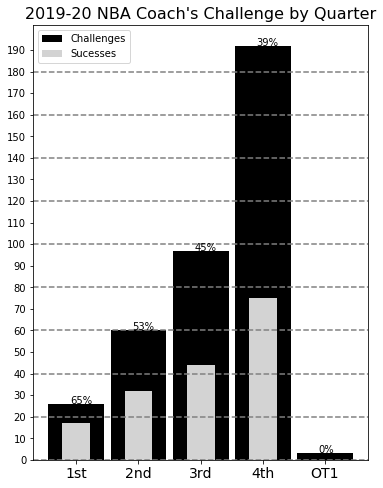

In [8]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes()

bar_width_po = 0.9
bar_width_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
hort_locations = np.arange(len(quarter_df))
#hort_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.bar(x=hort_locations,
        height=list(quarter_df['count']), width=bar_width_po,
        color='black', label = 'Challenges')
plt.bar(x=hort_locations,
        height=list(quarter_df['sum']), width=bar_width_league,
        color='lightgray', label = 'Sucesses')

count = 0
for perc, chal in zip(quarter_df['success_rate'], quarter_df['count']):
    plt.text(count-0.1, chal + 0.1, str(round(perc*100)) + '%')
    count += 1

plt.xticks(range(0, len(quarter_df)),
           quarter_df['Period'],
           rotation=0, fontsize=14)

plt.yticks(np.arange(0, max(quarter_df['count']) + 1, step=10))
for x in np.arange(0, max(quarter_df['count']) + 1, step=20):
    plt.axhline(x, linestyle='--', color='gray')
plt.title("2019-20 NBA Coach's Challenge by Quarter", fontsize=16)
plt.legend(loc='upper left')
plt.show()

Again, the above chart shows what one would expect. The volume of challenges increase by quarter. Given the low cost of a challenge, teams should be more willing to challenge a call as the end of the game approaches. Due to this, the probability of success lowers as the quarter increases.

Assuming that the rate of incorrect and challengeable plays is constant throughout a game, perhaps one could expect a more uniform distribution of challenges across quarters. This would suggest that teams are eschewing challenging calls early in the game in favor of saving the challenge should a more impactful situation arise. But given the declining rate of success across the game, these situations either arise less frequently as teams believe or their inability to identify them is poor.

In [9]:
league_id = '00' #NBA
date = datetime.today() - timedelta(days=5)
years = str(date.year)
if date.month <= 9:
    month = '0' + str(date.month)
else:
    month = str(date.month)
if date.day <= 9:
    day_str = '0' + str(date.day)
else:
    day_str = str(date.day)

date_str = month + '/' + day_str + '/' + years
day_offset = '0'

scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=date_str,
                               day_offset=day_offset)

game_id_list = [int(x['GAME_ID']) for x in scores.data['GameHeader']]
max_game = max(game_id_list)

In [10]:
# ref_df = pd.DataFrame()
# for game_id in range(21900001, max_game + 1):
#     print(game_id)
#     plays = boxscore.BoxScore(headers=HEADERS,
#                              endpoint='boxscoresummaryv2',
#                              game_id='00' + str(game_id))
    
#     official_df = pd.DataFrame(plays.data['Officials'])
#     official_df['NAME'] = [x + ' ' + y for x, y in zip(official_df['FIRST_NAME'],
#                                                        official_df['LAST_NAME'])]
#     official_str = ''
#     name_str = ''
#     for official, name in zip(official_df['OFFICIAL_ID'], official_df['NAME']):
#         official_str += str(official)
#         name_str += name
#         if official != list(official_df['OFFICIAL_ID'])[-1]:
#             official_str += '-'
#             name_str += '-'
#     chief = official_df['OFFICIAL_ID'].iloc[0]
#     chief_name = official_df['NAME'].iloc[0]
#     game_date = plays.data['GameSummary'][0]['GAME_DATE_EST'].replace('T00:00:00', '')
#     away_team = plays.data['GameSummary'][0]['GAMECODE'][-6:-3]
#     home_team = plays.data['GameSummary'][0]['GAMECODE'][-3:]

#     temp_df = pd.DataFrame({'OFFICIALS': [official_str],
#                             'NAMES': [name_str],
#                             'CHIEF': [chief],
#                             'CHIEF_NAME': [chief_name],
#                             'GAME_DATE': [game_date],
#                             'AWAY_TEAM': [away_team],
#                             'HOME_TEAM': [home_team]})
#     ref_df = pd.concat([ref_df, temp_df], axis=0)
#     time.sleep(1.5)

In [11]:
ref_df = pd.read_csv('ref.csv')#ref_df.to_csv('ref.csv')

## Challenges by Officiating Crew

The chief of the officiating crew is assumed to be the first referee listed in the data, which is an assumption and may not reflect the make up of a crew in reality. However, the chief is not indicated in the data. With this assumption, we have 45 unique chief referees across 652 games.

In [12]:
date_list = []
for date in challenge_df['Date']:
    if 'Oct' in date:
        month = '10'
        year = '2019'
    elif 'Nov' in date:
        month = '11'
        year = '2019'
    elif 'Dec' in date:
        month = '12'
        year = '2019'
    else:
        year = '2020'

    if '-' in date:
        day = date.split('-')[0]
    else:
        day = date.split(' ')[-1]

    date_list.append(year + '-' + month + '-' + day)

challenge_df['Date'] = date_list

In [13]:
challenge_df = challenge_df.merge(ref_df, left_on=['Date', 'Visiting', 'Home'],
                                  right_on=['GAME_DATE', 'AWAY_TEAM', 'HOME_TEAM'])

In [14]:
off_df = pd.DataFrame(challenge_df.groupby('CHIEF_NAME')['Success'].aggregate(['sum', 'count'])).reset_index()
off_df['success_rate'] = [0 if y == 0 else x/float(y) for x, y in zip(off_df['sum'], off_df['count'])]

off_df = off_df.sort_values(['sum', 'count', 'success_rate'], ascending=[True, True, False])
off_df['success_rate'] = [round(x, 2) for x in off_df['success_rate']]
off_df

,CHIEF_NAME,sum,count,success_rate
1,Bennie Adams,0,1,0.00
7,Curtis Blair,0,1,0.00
23,Kevin Scott,0,1,0.00
12,Eric Dalen,0,2,0.00
0,Ben Taylor,1,1,1.00
3,Bill Spooner,1,1,1.00
16,James Williams,1,1,1.00
20,Karl Lane,1,1,1.00
42,Tre Maddox,1,2,0.50
43,Zach Zarba,1,4,0.25


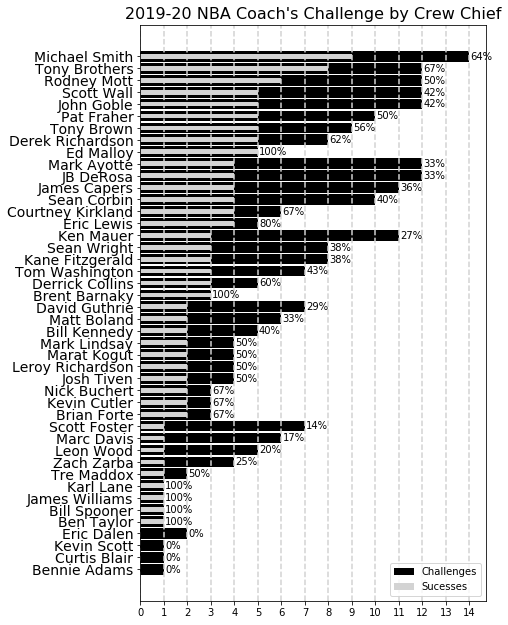

In [15]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes([0., 0., 0.8, 1., ])

# A nested bar chart should provide a nice visual
bar_height_po = 0.9
bar_height_league = 0.4

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
vert_locations = np.arange(len(off_df))
#vert_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.barh(y=vert_locations,
        width=list(off_df['count']), height=bar_height_po,
        color='black', label = 'Challenges')
plt.barh(y=vert_locations,
        width=list(off_df['sum']), height=bar_height_league,
        color='lightgray', label = 'Sucesses')

count = 0
for perc, chal in zip(off_df['success_rate'], off_df['count']):
    plt.text(chal + 0.05, count - 0.25, str(round(perc*100)) + '%')
    count += 1

plt.yticks(range(0, len(off_df)),
           off_df['CHIEF_NAME'],
           rotation=0, fontsize=14)

plt.xticks(np.arange(0, max(off_df['count']) + 1, step=1))
for x in np.arange(0, max(off_df['count']) + 1, step=1):
    plt.axvline(x, linestyle='--', color='lightgray')
plt.title("2019-20 NBA Coach's Challenge by Crew Chief", fontsize=16)
plt.legend(loc='lower right')
plt.show()

Michael Smith is tied for the lead in challenges and leads all crew chiefs in successful overturns, followed closely by Tony Brothers, a fairly unpopular official in the NBA. Ed Malloy has had all five challenges overturned with him as chief.
 
## Further Analysis

The above takes several slices of the available coach's challenge data and finds a few interesting takeaways.

- All teams fail to use the coach's challenge in more than half of their games
- Challengeable goaltending and out-of-bounds plays have a higher overturn rate, but are much less common than questionable called-fouls
- The volume of challenges increases while the success rate decreases as the game proceeds
- Challenges and successes are not evenly distributed across crew chiefs, which could be an indication of officiating quality

However, the information above might not be very actionable for teams. When deciding to challenge a given play, a team must weigh:

- The probability that the call will be overturned
- The change in win probability should the call be overturned
- The probability that a challengeable incorrect call will occur later in the game that provides a greater expected increase in win probability
- The value of the timeout that will potentially be lost

With proper estimates for all of the above, a team could develop a system to challenge plays that have an expected win probability increase greater than the potential win probability increase for potential challenges later in the game. Beyond simple heuristics, estimating that a given call will be overturned would be difficult with just data. The change in win probability should the call be overturned could be found with an in-game win probability model. Similarly, win probability and the challenge data could be used to estimate the likelihood of another challengeable call occurring. Lastly, the value of a late timeout could be estimated.

Pieces of the puzzle still remain without weighing the above factors. However, the analysis here should serve as a good initial glimpse at the NBA's challenge data. If you're interested in diving in on your own, here's a link to my [GitHub repository](https://github.com/basketballrelativity/challenges) that contains the challenge dataset along with a previous version of the above analysis.